# Stochastic neighbour embedding

 * http://lvdmaaten.github.io/tsne
 * [Original article](http://jmlr.csail.mit.edu/papers/volume9/vandermaaten08a/vandermaaten08a.pdf) and author [presentation video](https://www.youtube.com/watch?v=RJVL80Gg3lA)

Approximating a conditional probability distribution by learning embeddings $y_i$ of each data points
$$ p_{j|i} \approx q_{j|i} = \frac{ \exp ( - || y_i - y_j  ||^2) }{ \sum_{k\neq i} \exp ( - || y_i - y_k  ||^2) }$$
    

In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

torch.__version__

'0.4.0'

## Toy model

Transition probabilities between 3 states

In [2]:
n = 3
d = 2

points_to_clusters = [0, 1, 2]

p_ij = np.array([
    [.3, .6, .1],
     [.3, .4, .3],
     [.1, .6, .3]])

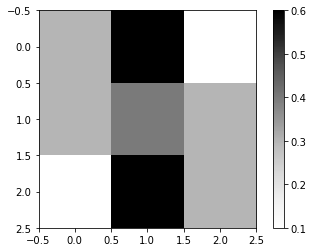

In [3]:
plt.imshow(p_ij, cmap='Greys')
plt.colorbar();

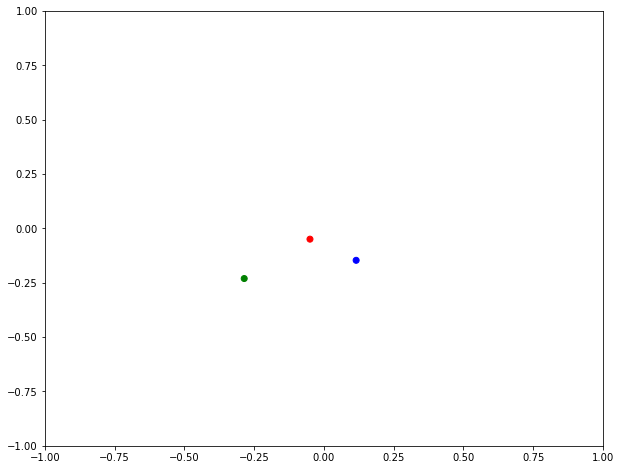

In [4]:
y_i = np.random.normal(scale=.25, size=(n, d))

def plot(y_i, points_to_clusters, ax=None, marker='o'):
    if ax is None:
        f, ax = plt.subplots(figsize=(10, 8))
    colors = np.array(['r', 'g', 'b'])
    ax.scatter(*y_i.T, color=colors[points_to_clusters], marker=marker)
    ax.set_xlim([-1, 1]); ax.set_ylim([-1, 1]);
    return ax

plot(y_i, points_to_clusters);

In [5]:
# Numpy broadcasting to perform cartesian product of nxn euclidean distances
# https://stackoverflow.com/a/37903795/230286

# (n x 1 x d) - (n x d) -> (n x n x d)
squared_distances_i_j_k = np.power(y_i[:, np.newaxis, :] - y_i, 2)
pairwise_squared_distances_i_j = squared_distances_i_j_k.sum(axis=2)

pairwise_squared_distances_i_j

array([[0.        , 0.08835925, 0.03685761],
       [0.08835925, 0.        , 0.16799446],
       [0.03685761, 0.16799446, 0.        ]])

In [6]:
unnormalized_q_i_j = np.exp(-pairwise_squared_distances_i_j)
q_i_j = unnormalized_q_i_j / unnormalized_q_i_j.sum(axis=1)

q_i_j

array([[0.34731323, 0.33158328, 0.34309519],
       [0.31794163, 0.3622151 , 0.30092802],
       [0.33474514, 0.30620162, 0.35597679]])

### Pytorch equivalent

In [7]:
import torch
import torch.autograd
from torch.autograd import Variable

In [8]:
def pairwise_squared_distances(y_i: torch.Tensor):
    # (n x 1 x d) - (n x d) -> (n x n x d)
    squared_distances_ijk = (y_i[:, None, :] - y_i) ** 2
    pairwise_squared_distances_ij = squared_distances_ijk.sum(2)    
    return pairwise_squared_distances_ij

pairwise_squared_distances(torch.from_numpy(y_i))

tensor([[ 0.0000,  0.0884,  0.0369],
        [ 0.0884,  0.0000,  0.1680],
        [ 0.0369,  0.1680,  0.0000]], dtype=torch.float64)

In [9]:
def approximated_probs(embeddings_i: torch.Tensor):
    pairwise_squared_distances_ij = pairwise_squared_distances(embeddings_i)
    unnormalized_q_ij = (-pairwise_squared_distances_ij).exp()
    q_ij = unnormalized_q_ij / unnormalized_q_ij.sum(1)

    return q_ij

approximated_probs(torch.from_numpy(y_i))

tensor([[ 0.3473,  0.3316,  0.3431],
        [ 0.3179,  0.3622,  0.3009],
        [ 0.3347,  0.3062,  0.3560]], dtype=torch.float64)

### Quick primer on [KL divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence)

 * roots in information theory (relative entropy)
 * "measures how one probability distribution diverges from a second distribution".
 * Well behaved cost function (differentiable) 
 * Not a distance because assymetric:

![title](https://image.slidesharecdn.com/vbtechtalk-150727192410-lva1-app6892/95/variational-inference-13-638.jpg?cb=1438030914)

### Back to the T-SNE cost function

KL divergence between $P_i$ and $Q_i$

Equation (3)

$$
\sum_i \text{KL} (P_i||Qi) = \sum_i \sum_j p_{j|i} \log \frac{p_{j|i}}{q_{j|i}}
$$

In [10]:
q_ij = approximated_probs(torch.from_numpy(y_i))
q_ij

tensor([[ 0.3473,  0.3316,  0.3431],
        [ 0.3179,  0.3622,  0.3009],
        [ 0.3347,  0.3062,  0.3560]], dtype=torch.float64)

In [11]:
def kl_divergence(p_ij: torch.Tensor, q_ij: torch.Tensor):
    return (p_ij * (q_ij.log() - p_ij.log())).sum()

kl = kl_divergence(torch.from_numpy(p_ij), q_ij)

kl

tensor(-0.4414, dtype=torch.float64)

## Gradient through loss back-propagation

array([[-0.08211986, -0.04960628],
       [-0.2399575 , -0.21342072],
       [ 0.10156559, -0.16432029]])

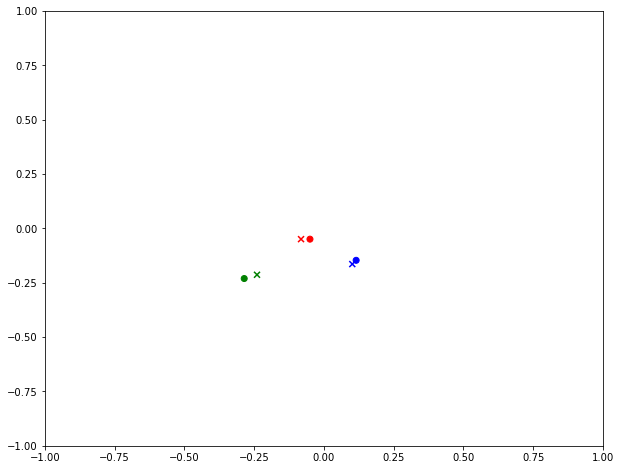

In [15]:
def updated_embeddings(current_y_i: np.array, p_ij: np.array, learning_rate=.2):
    embeddings_i = Variable(torch.from_numpy(current_y_i), requires_grad=True)
    
    loss = kl_divergence(torch.from_numpy(p_ij), q_ij=approximated_probs(embeddings_i))

    loss.backward()
    embeddings_gradient_i = embeddings_i.grad.data.numpy()

    return current_y_i + learning_rate * embeddings_gradient_i

updated_y_i = updated_embeddings(y_i, p_ij)

ax = plot(y_i, points_to_clusters)
plot(updated_y_i, points_to_clusters, ax, marker='x')

updated_y_i

## Illustration on a slightly more interesting dataset

$n$ individual data points spread accross 3 clusters, $p_ij$ depends on the cluster

In [16]:
inter_p_ij = np.array(
    [[.3, .6, .1],
     [.3, .4, .3],
     [.1, .6, .3]])

n = 75
points_to_clusters = np.repeat([0, 1, 2], repeats=25)

p_ij = np.vstack([
    np.repeat(inter_p_ij[0], repeats=25),
    np.repeat(inter_p_ij[1], repeats=25),
    np.repeat(inter_p_ij[2], repeats=25)])[points_to_clusters]

p_ij = p_ij / p_ij.sum(1)

points_to_clusters

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2])

In [17]:
y_i = np.random.normal(scale=.25, size=(n, d))
current_y_i = y_i

print(p_ij.shape)
print(current_y_i.shape)

(75, 75)
(75, 2)


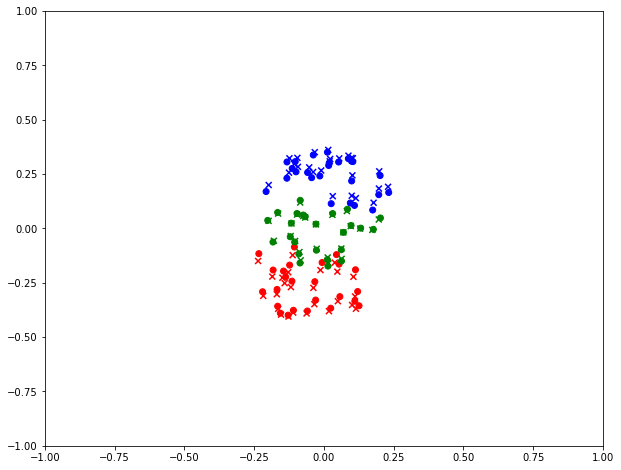

In [34]:
# Execute repeatedly with Ctrl + Enter
embeddings_i = Variable(torch.from_numpy(current_y_i), requires_grad=True)
loss = kl_divergence(torch.from_numpy(p_ij), q_ij=approximated_probs(embeddings_i))
loss.backward()

learning_rate = .2
updated_y_i = current_y_i + learning_rate * embeddings_i.grad.data.numpy()

ax = plot(current_y_i, points_to_clusters)
plot(updated_y_i, points_to_clusters, ax, marker='x')

current_y_i = updated_y_i

## Real data set

In [208]:
import bs4
import requests

html = requests.get('http://www.oocities.org/Axiom43/ukdistance.html').text()

bs4.BeautifulSoup(html).find('span')

'<!DOCTYPE HTML PUBLIC>\n<meta name="viewport" content="width=device-width, initial-scale=1">\n<meta http-equiv="Cache-control" content="public, min-fresh:10000000">\n<script language="JavaScript" type="text/javascript">\nif (window == top) { document.write(\'<div style="height:30px;"></div><div id="content" style="max-width:1010px;overflow:auto">\');}\nelse {document.write(\'<div id="content" style="max-width:800px;overflow:auto">\');} </script>\n\n<script language="JavaScript">var PUpage="76001067"; var PUprop="geocities"; </script><script language="JavaScript" src="http://www.oocities.com/js_source/pu5geo.js"></script><script language="JavaScript"> var thGetOv="http://themis.geocities.yahoo.com/themis/h.php"; var thCanURL="http://us.oocities.com/axiom43/ukdistance.html"; var thSpaceId="76001067"; var thIP="94.23.45.160"; var thTs="1255588096"; var thCs="627e9d0c93e53aeccaa82d745b516b8e";</script><noscript><link rel="stylesheet" href="http://themis.geocities.yahoo.com/jsoff.css?thIP=

In [203]:
import pandas as pd

tables = pd.read_html('http://www.oocities.org/Axiom43/ukdistance.html')

In [204]:
tables[0]

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,United Kingdom Distance Chart,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,York,Southampton,Sheffield,Portsmouth,Oxford,Nottingham,Norwich,Newcastle,Manchester,London,...,Exeter,Edinburgh,Dover,Derby,Cardiff,Bristol,Birmingham,Aberystwyth,Aberdeen,.
2,3071951292172318826418629221034425971946582181...,5381981287411815414341810741957522921777208319...,3471567616417837229227240241385347216038128146...,5522181419413817513143112443258924223171222332...,4731576370104901293531413545111641535614425414...,3791564913715116196259213279416709912371159123...,4802711612092351391563602823835171742171121852...,22825920428830116134310736414526594155274131-2...,33313181162173592572132382143714134184-1311857...,49221211111415012374372170389529191198-1842741...,...,56519916475120203244444-4466022712371702383642...,121320290369373263442-444451581932143722131073...,563285185189228196-442244466600257270742573431...,38414040127142-1962632032704197081123591611391...,49311010244-1422283731203745302081651501733012...,49012488-4412718936975371527196161114162288209...,411116-881024018529016429244811090111812041614...,440-116124110140285320199321477171105212131259...,-440411490493384563121565141107314335492333228...,AberdeenAberystwythBirminghamBristolCardiffDer...
3,The above are the shortest practical routes by...,Distances given are in miles.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,There may be shorter routes if you chose to us...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [206]:
tables[0].iloc[2, 0]

'30719512921723188264186292210344259719465821818017425253239-'